# APIs para modelos de Machine Learning

## Introducción

En este notebook vamos a ver cómo podemos exponer un modelo de Machine Learning a través de una API. Para ello, vamos a utilizar la librería `fastapi` que nos permite crear APIs de forma sencilla y rápida. También trabajaremos con scikit-learn para entrenar un modelo de clasificación y guardarlo en disco para luego exponerlo a través de la API.

Utilizaremos el dataset de UCI llamado `adult` que contiene información sobre personas y su salario. El objetivo es predecir si una persona gana más de 50k al año o no.

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
  
# metadata 
#print(adult.metadata) 
  
# variable information 
#adult.variables 

In [3]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [4]:
y.head()

,income
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K


En este ejercicio consideraremos tres componentes importantes en la creación de un modelo de una clasificación supervisada. Decimos que es supervisada porque el modelo se entrena con ejemplos que ya tienen la etiqueta que queremos predecir.

1. **Preprocesamiento de datos**: En esta etapa vamos a cargar el dataset, limpiarlo y transformar las variables categóricas en numéricas.

2. **Entrenamiento del modelo**: Utilizaremos un modelo de clasificación llamado `RandomForestClassifier` que se encuentra en la librería `scikit-learn`. Este modelo es un ensamble de árboles de decisión.

3. **Predicción**: Finalmente, vamos a exponer el modelo a través de una API para que cualquier persona pueda hacer predicciones.


Compilaremos estas tres componentes a traves de un Pipeline de scikit-learn, es muy importante tener en cuenta que este proceso aplica para cualquier modelo de clasificación supervisada, LO QUE IMPLICA QUE PUEDE REUTILIZARSE Y REVISARSE CUANDO ESTUDIE OTROS MODELOS DE MACHINE LEARNING.

## Como funciona un modelo de clasificación supervisada

Un modelo de clasificación supervisada es un algoritmo que aprende a predecir la etiqueta de una variable objetivo a partir de un conjunto de variables predictoras. En nuestro caso, queremos predecir si una persona gana más de 50k al año o no. Por lo tanto, la variable objetivo es `income` y las variables predictoras son `age`, `workclass`, `education`, `marital-status`, `occupation`, `relationship`, `race`, `sex`, `capital-gain`, `capital-loss`, `hours-per-week` y `native-country`.

La idea es que al exponer datos que el modelo no ha visto antes, pueda predecir la etiqueta de la variable objetivo. Por eso decimos que el modelo aprendió a partir de ejemplos previos.

### Exploracion de datos

Vamos a cargar el dataset y ver algunas estadísticas descriptivas.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Transformación de los datos en un dataframe de pandas

df = pd.DataFrame(X, columns=adult.variables.name[:-1])
df['Income'] = y

# Visualización de los primeros registros
df.head()

name,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
### Análisis exploratorio de datos

# Información general del dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  Income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [7]:
### Análisis de valores nulos

# Verificación de valores nulos

df.isnull().sum()

name
age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
Income              0
dtype: int64

In [8]:
### Análisis de valores duplicados

# Verificación de valores duplicados

df=df.drop_duplicates()
df

name,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [9]:
### Análisis de la variable objetivo

# Distribución de la variable objetivo

df['Income'].value_counts()



Income
<=50K     24698
<=50K.    12430
>50K       7839
>50K.      3846
Name: count, dtype: int64

In [10]:
(df['Income']=='>50K').value_counts()

Income
False    40974
True      7839
Name: count, dtype: int64

In [11]:
### Arreglo de la variable objetivo

# Reemplazo de los valores de la variable objetivo

df['Income'] = df['Income'].replace({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})
df['Income'].value_counts()

/tmp/ipykernel_22947/797159872.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Income'] = df['Income'].replace({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})


Income
0    37128
1    11685
Name: count, dtype: int64

In [12]:
### Análisis de las variables numéricas

# Estadísticas descriptivas de las variables numéricas

df.describe()

name,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,Income
count,48813.000000,4.881300e+04,48813.000000,48813.000000,48813.000000,48813.000000,48813.000000
mean,38.647348,1.896679e+05,10.078688,1079.708705,87.554299,40.425051,0.239383
std,13.709005,1.056062e+05,2.570257,7454.185982,403.118605,12.390954,0.426711
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.175550e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.781400e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.376200e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [13]:
### Análisis de las variables categóricas

# Estadísticas descriptivas de las variables categóricas

df.describe(include='object')

name,workclass,education,marital-status,occupation,relationship,race,sex,native-country
count,47850,48813,48813,47847,48813,48813,48813,48539
unique,9,16,7,15,6,5,2,42
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,33879,15777,22372,6167,19709,41736,32631,43810


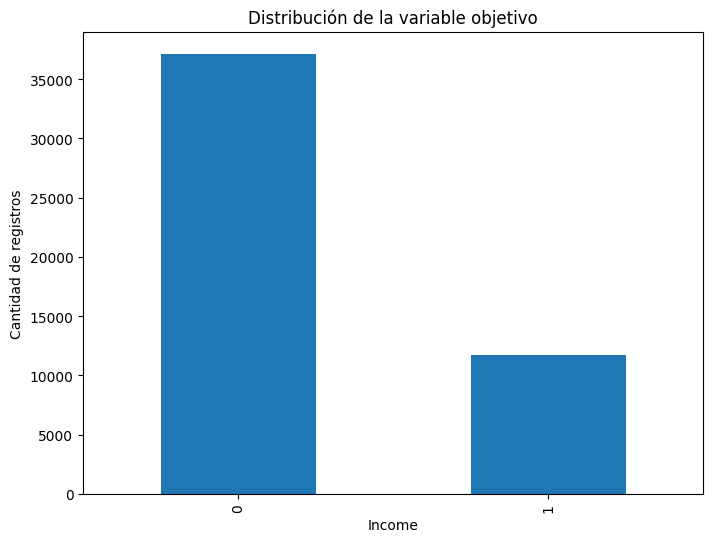

In [14]:
### Visualización de la variable objetivo

# Gráfico de barras de la variable objetivo

plt.figure(figsize=(8, 6))
plt.title('Distribución de la variable objetivo')
plt.xlabel('Ingresos')
plt.ylabel('Cantidad de registros')
df['Income'].value_counts().plot(kind='bar')
plt.show()

In [15]:
### tratamiento de variables 

# Transformación de las variables categóricas

df['workclass'].value_counts(dropna=False)

workclass
Private             33879
Self-emp-not-inc     3861
Local-gov            3136
State-gov            1981
?                    1836
Self-emp-inc         1694
Federal-gov          1432
NaN                   963
Without-pay            21
Never-worked           10
Name: count, dtype: int64

In [35]:
X

name,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States
48838,64,NaN,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States
48839,38,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States
48840,44,Private,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States


In [36]:
y

0        0
1        0
2        0
3        0
4        0
        ..
48837    0
48838    0
48839    0
48840    0
48841    1
Name: Income, Length: 48813, dtype: int64

In [38]:
#### preprocesamiento de datos

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Separación de las variables predictoras y la variable objetivo

X = df.drop(['Income','fnlwgt'], axis=1)
y = df['Income']

### Partcionamos el dataset

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=2025)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(39050, 13)
(9763, 13)
(39050,)
(9763,)


In [40]:
### En X buscamos las columnas categoricas y las numericas

# Identificación de las columnas numéricas y categóricas

columnas_numericas = X_train.select_dtypes(exclude='object').columns
columnas_numericas

Index(['age', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object', name='name')

In [41]:
columnas_categoricas = X_train.select_dtypes(include='object').columns
columnas_categoricas

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object', name='name')

In [21]:
### Definimos los pasos para el preprocesamiento de los datos

transfomacion_OHE = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [22]:
### Ejemplo de uso

df_workclass=pd.DataFrame(transfomacion_OHE.fit_transform(X[['workclass']]))
columns=transfomacion_OHE.get_feature_names_out()
df_workclass.columns=columns
df_workclass.head()

,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,workclass_nan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [23]:

df_cat=pd.DataFrame(transfomacion_OHE.fit_transform(X[columnas_categoricas]))
columns=transfomacion_OHE.get_feature_names_out()
df_cat.columns=columns
df_cat.head()


print(transfomacion_OHE.fit_transform(X[columnas_categoricas]).shape)



(48813, 105)


In [24]:
### SimpleImputer
print(X[['occupation']].value_counts(dropna=False))

transformacion_nan= SimpleImputer(strategy='constant', fill_value='?')

pd.DataFrame(transformacion_nan.fit_transform(X[['occupation']])).value_counts()

occupation       
Prof-specialty       6167
Craft-repair         6107
Exec-managerial      6084
Adm-clerical         5608
Sales                5504
Other-service        4919
Machine-op-inspct    3019
Transport-moving     2355
Handlers-cleaners    2071
?                    1843
Farming-fishing      1487
Tech-support         1445
Protective-serv       983
NaN                   966
Priv-house-serv       240
Armed-Forces           15
Name: count, dtype: int64


0                
Prof-specialty       6167
Craft-repair         6107
Exec-managerial      6084
Adm-clerical         5608
Sales                5504
Other-service        4919
Machine-op-inspct    3019
?                    2809
Transport-moving     2355
Handlers-cleaners    2071
Farming-fishing      1487
Tech-support         1445
Protective-serv       983
Priv-house-serv       240
Armed-Forces           15
Name: count, dtype: int64

In [25]:
### Normalización de las variables numéricas

display(X[columnas_numericas].describe())

transformacion_escalar = StandardScaler()

pd.DataFrame(transformacion_escalar.fit_transform(X[columnas_numericas])).describe()

name,age,education-num,capital-gain,capital-loss,hours-per-week
count,48813.000000,48813.000000,48813.000000,48813.000000,48813.000000
mean,38.647348,10.078688,1079.708705,87.554299,40.425051
std,13.709005,2.570257,7454.185982,403.118605,12.390954
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


,0,1,2,3,4
count,4.881300e+04,4.881300e+04,4.881300e+04,4.881300e+04,4.881300e+04
mean,-2.352318e-16,-2.403266e-16,1.353747e-17,-5.254869e-17,2.039355e-16
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00
min,-1.579077e+00,-3.532247e+00,-1.448474e-01,-2.171946e-01,-3.181793e+00
25%,-7.766762e-01,-4.196854e-01,-1.448474e-01,-2.171946e-01,-3.430366e-02
50%,-1.201666e-01,-3.061518e-02,-1.448474e-01,-2.171946e-01,-3.430366e-02
75%,6.822339e-01,7.475252e-01,-1.448474e-01,-2.171946e-01,3.692206e-01
max,3.745945e+00,2.303806e+00,1.327044e+01,1.058867e+01,4.727283e+00


In [ ]:
### Transformación de las variables
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Creación de los pasos para el preprocesamiento

## El tratamiento en variables categoricas
transformacion_nan=SimpleImputer(strategy='constant', fill_value='?')
transfomacion_OHE=OneHotEncoder(sparse_output=False, handle_unknown='ignore')

pasos_categoricas = [
    ('imputacion', transformacion_nan),
    ('codificacion', transfomacion_OHE),]

### El tratamiento en variables numericas

transformacion_escalar=StandardScaler()
pasos_numericas=[('normalizacion_escalar',transformacion_escalar)]


pipeline_categorico=Pipeline(pasos_categoricas)
pipeline_numerico=Pipeline(pasos_numericas)

# Creación del preprocesador
Transformacion_Columnas = ColumnTransformer(
    transformers=[('Tratamiento_categorico',pipeline_categorico, columnas_categoricas),    ('Tratamiento_numerico',pipeline_numerico, columnas_numericas),                
                  ])

Transformacion_Columnas

ColumnTransformer(transformers=[('Tratamiento_categorico',
                                 Pipeline(steps=[('imputacion',
                                                  SimpleImputer(fill_value='?',
                                                                strategy='constant')),
                                                 ('codificacion',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object', name='name')),
                                ('Tratamiento_numerico',
                                 Pipeline(steps=[('normalizacion_escalar',
                                                  StandardScaler())]),
                                 Index(['age', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object', name='name'))])

In [44]:
Transformacion_Columnas.fit(X_train)

Transformacion_Columnas.transform(X_train)

array([[ 0.        ,  0.        ,  0.        , ..., -0.14521249,
        -0.21645429, -0.03658245],
       [ 0.        ,  0.        ,  0.        , ..., -0.14521249,
        -0.21645429, -0.83958679],
       [ 0.        ,  0.        ,  0.        , ..., -0.14521249,
        -0.21645429,  0.60582102],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.14521249,
         3.93503417,  1.56942623],
       [ 0.        ,  0.        ,  1.        , ..., -0.14521249,
        -0.21645429,  0.76642189],
       [ 0.        ,  0.        ,  1.        , ..., -0.14521249,
        -0.21645429,  1.56942623]], shape=(39050, 107))

In [57]:
Transformacion_Columnas.transformers_[0][1].steps[1][1]

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [56]:
columnas_categoricas_Nuevas=Transformacion_Columnas.transformers_[0][1].steps[1][1].get_feature_names_out()

DF_salida=pd.DataFrame(Transformacion_Columnas.transform(X_train),columns=columnas_categoricas_Nuevas.tolist()+columnas_numericas.tolist())
DF_salida

,x0_?,x0_Federal-gov,x0_Local-gov,x0_Never-worked,x0_Private,x0_Self-emp-inc,x0_Self-emp-not-inc,x0_State-gov,x0_Without-pay,x1_10th,...,x7_Thailand,x7_Trinadad&Tobago,x7_United-States,x7_Vietnam,x7_Yugoslavia,age,education-num,capital-gain,capital-loss,hours-per-week
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-0.922365,1.136724,-0.145212,-0.216454,-0.036582
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-0.703360,-0.421252,-0.145212,-0.216454,-0.839587
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.464669,-0.031758,-0.145212,-0.216454,0.605821
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-0.776362,0.357736,-0.145212,-0.216454,0.364920
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.464669,-0.421252,-0.145212,-0.216454,-0.036582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39045,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.172662,1.915712,-0.145212,-0.216454,0.364920
39046,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-1.287374,-2.368722,-0.145212,-0.216454,-0.036582
39047,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-0.776362,-0.031758,-0.145212,3.935034,1.569426
39048,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-0.265349,1.136724,-0.145212,-0.216454,0.766422


In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Creación del modelo

random_forest = RandomForestClassifier(n_estimators=50,random_state=2025)

# Entrenamiento del modelo
random_forest.fit(Transformacion_Columnas.transform(X_train), y_train)

random_forest

RandomForestClassifier(n_estimators=50, random_state=2025)

In [64]:
y_pred=random_forest.predict(Transformacion_Columnas.transform(X_test)) 
y_pred

array([0, 0, 1, ..., 0, 0, 0], shape=(9763,))

In [65]:
confusion_matrix(y_test,y_pred)

array([[6816,  603],
       [ 881, 1463]])

In [67]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      7419
           1       0.71      0.62      0.66      2344

    accuracy                           0.85      9763
   macro avg       0.80      0.77      0.78      9763
weighted avg       0.84      0.85      0.84      9763



In [69]:
### No es tan chevre el modelo, veamos otro

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Creación del modelo

random_forest = RandomForestClassifier(n_estimators=120,max_depth=10,random_state=2025)

# Entrenamiento del modelo
random_forest.fit(Transformacion_Columnas.transform(X_train), y_train)

## Evaluación del modelo

y_pred=random_forest.predict(Transformacion_Columnas.transform(X_test))

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[7098  321]
 [1032 1312]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      7419
           1       0.80      0.56      0.66      2344

    accuracy                           0.86      9763
   macro avg       0.84      0.76      0.79      9763
weighted avg       0.86      0.86      0.85      9763



In [77]:
### Revisemos varios modelos a la vez con GridSearchCV

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Creación del modelo

random_forest = RandomForestClassifier(random_state=2025)

# Definición de los hiperparámetros

parametros = {
    'n_estimators': [50, 100, 150,300],
    'max_depth': [5, 10, 15, 20,30],
    'criterion': ['gini', 'entropy']
}

# Búsqueda de los mejores hiperparámetros

grid = GridSearchCV(random_forest, param_grid=parametros, cv=5, n_jobs=-1,verbose=2)

from sklearn.pipeline import Pipeline

# Creación del pipeline

pipeline = Pipeline(steps=[('preprocesamiento', Transformacion_Columnas),
                           ('modelo', grid)])

pipeline

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('Tratamiento_categorico',
                                                  Pipeline(steps=[('imputacion',
                                                                   SimpleImputer(fill_value='?',
                                                                                 strategy='constant')),
                                                                  ('codificacion',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-...
                                                  Pipeline(steps=[('normalizacion_escalar',
                                                                   StandardScaler())]),
                                                  Index(['age', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object', name='name'))])),
                ('modelo',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(random_state=2025),
                              n_jobs=-1,
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [5, 10, 15, 20, 30],
                                          'n_estimators': [50, 100, 150, 300]},
                              verbose=2))])

In [78]:
pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END .......criterion=gini, max_depth=5, n_estimators=50; total time=   3.2s
[CV] END .......criterion=gini, max_depth=5, n_estimators=50; total time=   3.4s
[CV] END .......criterion=gini, max_depth=5, n_estimators=50; total time=   3.7s
[CV] END .......criterion=gini, max_depth=5, n_estimators=50; total time=   3.9s
[CV] END .......criterion=gini, max_depth=5, n_estimators=50; total time=   4.2s
[CV] END ......criterion=gini, max_depth=5, n_estimators=100; total time=   6.6s
[CV] END ......criterion=gini, max_depth=5, n_estimators=100; total time=   7.0s
[CV] END ......criterion=gini, max_depth=5, n_estimators=100; total time=   7.2s
[CV] END ......criterion=gini, max_depth=5, n_estimators=100; total time=   7.4s
[CV] END ......criterion=gini, max_depth=5, n_estimators=100; total time=   7.8s
[CV] END ......criterion=gini, max_depth=5, n_estimators=150; total time=   9.4s
[CV] END ......criterion=gini, max_depth=5, n_e

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('Tratamiento_categorico',
                                                  Pipeline(steps=[('imputacion',
                                                                   SimpleImputer(fill_value='?',
                                                                                 strategy='constant')),
                                                                  ('codificacion',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-...
                                                  Pipeline(steps=[('normalizacion_escalar',
                                                                   StandardScaler())]),
                                                  Index(['age', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object', name='name'))])),
                ('modelo',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(random_state=2025),
                              n_jobs=-1,
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [5, 10, 15, 20, 30],
                                          'n_estimators': [50, 100, 150, 300]},
                              verbose=2))])

In [79]:
### Entrenamos un monton de modelos

## Veamos el mejor

pipeline.named_steps['modelo'].best_params_

{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 150}

In [80]:
### Evaluación del mejor modelo

y_pred = pipeline.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[7026  393]
 [ 927 1417]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      7419
           1       0.78      0.60      0.68      2344

    accuracy                           0.86      9763
   macro avg       0.83      0.78      0.80      9763
weighted avg       0.86      0.86      0.86      9763



In [81]:
### Guardamos el pipeline

import joblib

# Guardar el modelo

joblib.dump(pipeline, 'pipeline.pkl')

['pipeline.pkl']

In [83]:
### Cargar el modelo

modelo_cargado= joblib.load('pipeline.pkl')

modelo_cargado.predict(X_test.iloc[:5])

array([0, 0, 1, 0, 0])